# Component 2: Product Quantization Benchmark

In [9]:
import sys
import os
import time
sys.path.append("Components")
from product_quantization import ProductQuantizer
from evaluation import compute_recall_at_k, compute_ndcg_at_k, compute_precision_at_k, compute_f1_at_k

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

np.random.seed(42)
np.set_printoptions(precision=4, suppress=True)

In [10]:
doc_vectors = np.load("Data/processed/doc_vectors_w2v.npy")
metadata = pd.read_csv("Data/processed/doc_metadata.csv")

print(f"Vectors: {doc_vectors.shape}")
print(f"Metadata: {metadata.shape[0]} records")

Vectors: (17830, 200)
Metadata: 17830 records


## Helper Functions

In [11]:
# Evaluation metrics imported from Components/evaluation.py
# Following Manning et al., "Introduction to Information Retrieval", Chapter 8
# 
# Available metrics:
# - compute_recall_at_k(predicted, actual, k)    : Recall@k
# - compute_precision_at_k(predicted, actual, k) : Precision@k (= Recall@k in ANN)
# - compute_f1_at_k(predicted, actual, k)        : F1@k (= Recall@k when P=R)
# - compute_ndcg_at_k(predicted, actual, k)      : Normalized DCG@k
# - compute_map(predictions, actuals)            : Mean Average Precision

print("✓ Evaluation metrics loaded from Components/evaluation.py")

✓ Evaluation metrics loaded from Components/evaluation.py


## Experiment 1: Accuracy vs Efficiency (vary m)

In [12]:
TOP_K = 10
N_QUERIES = 50
K = 256

query_indices = np.random.choice(len(doc_vectors), N_QUERIES, replace=False)

# Ground truth: exact nearest neighbors
exact_results = {}
for qi in query_indices:
    dists = euclidean_distances(doc_vectors[qi:qi+1], doc_vectors).ravel()
    exact_results[qi] = np.argsort(dists)[:TOP_K]

results = []
for m in [2, 4, 8]:
    print(f"Testing m={m} subvectors")
    pq = ProductQuantizer(n_subvectors=m, n_clusters=K)
    pq.fit(doc_vectors)
    pq.encode(doc_vectors)
    
    recalls = []
    ndcgs = []
    query_times = []
    
    for qi in query_indices:
        t0 = time.perf_counter()
        indices, _ = pq.search(doc_vectors[qi], top_k=TOP_K)
        query_times.append(time.perf_counter() - t0)
        
        recalls.append(compute_recall_at_k(indices, exact_results[qi], TOP_K))
        ndcgs.append(compute_ndcg_at_k(indices, exact_results[qi], TOP_K))
    
    results.append({
        "method": "PQ",
        "m_subvectors": m,
        "k_clusters": K,
        "recall_at_k": np.mean(recalls),
        "ndcg_at_k": np.mean(ndcgs),
        "candidate_ratio": 1.0,
        "query_time": np.mean(query_times),
        "N": len(doc_vectors),
        "dim": doc_vectors.shape[1],
        "compression_ratio": doc_vectors.nbytes / pq.codebook.nbytes,
    })

df_exp1 = pd.DataFrame(results)
print("\n=== Experiment 1: Accuracy vs Efficiency ===")
display(df_exp1)

Testing m=2 subvectors
Training PQ: 17830 vectors, 200 dims -> 2 subspaces of dim 100
Training complete.
Testing m=4 subvectors
Training PQ: 17830 vectors, 200 dims -> 4 subspaces of dim 50
Training complete.
Testing m=8 subvectors
Training PQ: 17830 vectors, 200 dims -> 8 subspaces of dim 25
Training complete.

=== Experiment 1: Accuracy vs Efficiency ===


,method,m_subvectors,k_clusters,recall_at_k,ndcg_at_k,candidate_ratio,query_time,N,dim,compression_ratio
0,PQ,2,256,0.160,0.203406,1.0,0.001148,17830,200,200.0
1,PQ,4,256,0.236,0.331588,1.0,0.002067,17830,200,100.0
2,PQ,8,256,0.330,0.439670,1.0,0.002262,17830,200,50.0


## Experiment 2: Scaling with N

In [13]:
N_LIST = [1000, 2000, 5000, 10000, min(20000, len(doc_vectors))]
TEST_QUERIES = 10
BEST_M = 4

scaling_results = []

for N in N_LIST:
    print(f"Testing N={N}")
    X = doc_vectors[:N]
    test_idx = np.random.choice(N, TEST_QUERIES, replace=False)
    
    pq = ProductQuantizer(n_subvectors=BEST_M, n_clusters=K)
    t0 = time.perf_counter()
    pq.fit(X)
    pq.encode(X)
    build_t = time.perf_counter() - t0
    
    q_times = []
    for qi in test_idx:
        t1 = time.perf_counter()
        pq.search(X[qi], top_k=TOP_K)
        q_times.append(time.perf_counter() - t1)
    
    scaling_results.append({
        "method": "PQ",
        "N": N,
        "dim": X.shape[1],
        "build_time": build_t,
        "query_time": np.mean(q_times),
    })

df_exp2 = pd.DataFrame(scaling_results)
print("\n=== Experiment 2: Scaling with N ===")
display(df_exp2)

Testing N=1000
Training PQ: 1000 vectors, 200 dims -> 4 subspaces of dim 50
Training complete.
Testing N=2000
Training PQ: 2000 vectors, 200 dims -> 4 subspaces of dim 50
Training complete.
Testing N=5000
Training PQ: 5000 vectors, 200 dims -> 4 subspaces of dim 50
Training complete.
Testing N=10000
Training PQ: 10000 vectors, 200 dims -> 4 subspaces of dim 50
Training complete.
Testing N=17830
Training PQ: 17830 vectors, 200 dims -> 4 subspaces of dim 50
Training complete.

=== Experiment 2: Scaling with N ===


,method,N,dim,build_time,query_time
0,PQ,1000,200,0.569202,0.000660
1,PQ,2000,200,0.880522,0.000872
2,PQ,5000,200,1.568169,0.000645
3,PQ,10000,200,2.506335,0.003380
4,PQ,17830,200,4.219900,0.002211


## Experiment 3: Scaling with Dimensionality

In [14]:
DIM_LIST = [50, 100, 200]
N_SAMPLE = 10000
TEST_QUERIES = 10

dim_results = []
X_sample = doc_vectors[:N_SAMPLE]

for d in DIM_LIST:
    print(f"Testing d={d}")
    X = X_sample[:, :d]
    test_idx = np.random.choice(N_SAMPLE, TEST_QUERIES, replace=False)
    
    m = max(2, d // 50)
    pq = ProductQuantizer(n_subvectors=m, n_clusters=K)
    t0 = time.perf_counter()
    pq.fit(X)
    pq.encode(X)
    build_t = time.perf_counter() - t0
    
    q_times = []
    for qi in test_idx:
        t1 = time.perf_counter()
        pq.search(X[qi], top_k=TOP_K)
        q_times.append(time.perf_counter() - t1)
    
    dim_results.append({
        "method": "PQ",
        "N": N_SAMPLE,
        "dim": d,
        "build_time": build_t,
        "query_time": np.mean(q_times),
    })

df_exp3 = pd.DataFrame(dim_results)
print("\n=== Experiment 3: Scaling with Dimensionality ===")
display(df_exp3)

Testing d=50
Training PQ: 10000 vectors, 50 dims -> 2 subspaces of dim 25
Training complete.
Testing d=100
Training PQ: 10000 vectors, 100 dims -> 2 subspaces of dim 50
Training complete.
Testing d=200
Training PQ: 10000 vectors, 200 dims -> 4 subspaces of dim 50
Training complete.

=== Experiment 3: Scaling with Dimensionality ===


,method,N,dim,build_time,query_time
0,PQ,10000,50,0.803253,0.001076
1,PQ,10000,100,0.955437,0.000809
2,PQ,10000,200,1.604629,0.000987


## Save Results

In [15]:
results_dir = "Data/results"
os.makedirs(results_dir, exist_ok=True)

df_exp1.to_csv(f"{results_dir}/pq_accuracy_efficiency.csv", index=False)
df_exp2.to_csv(f"{results_dir}/pq_scaling_N.csv", index=False)
df_exp3.to_csv(f"{results_dir}/pq_scaling_dim.csv", index=False)

print("✓ All PQ results saved")

✓ All PQ results saved


## Visualization

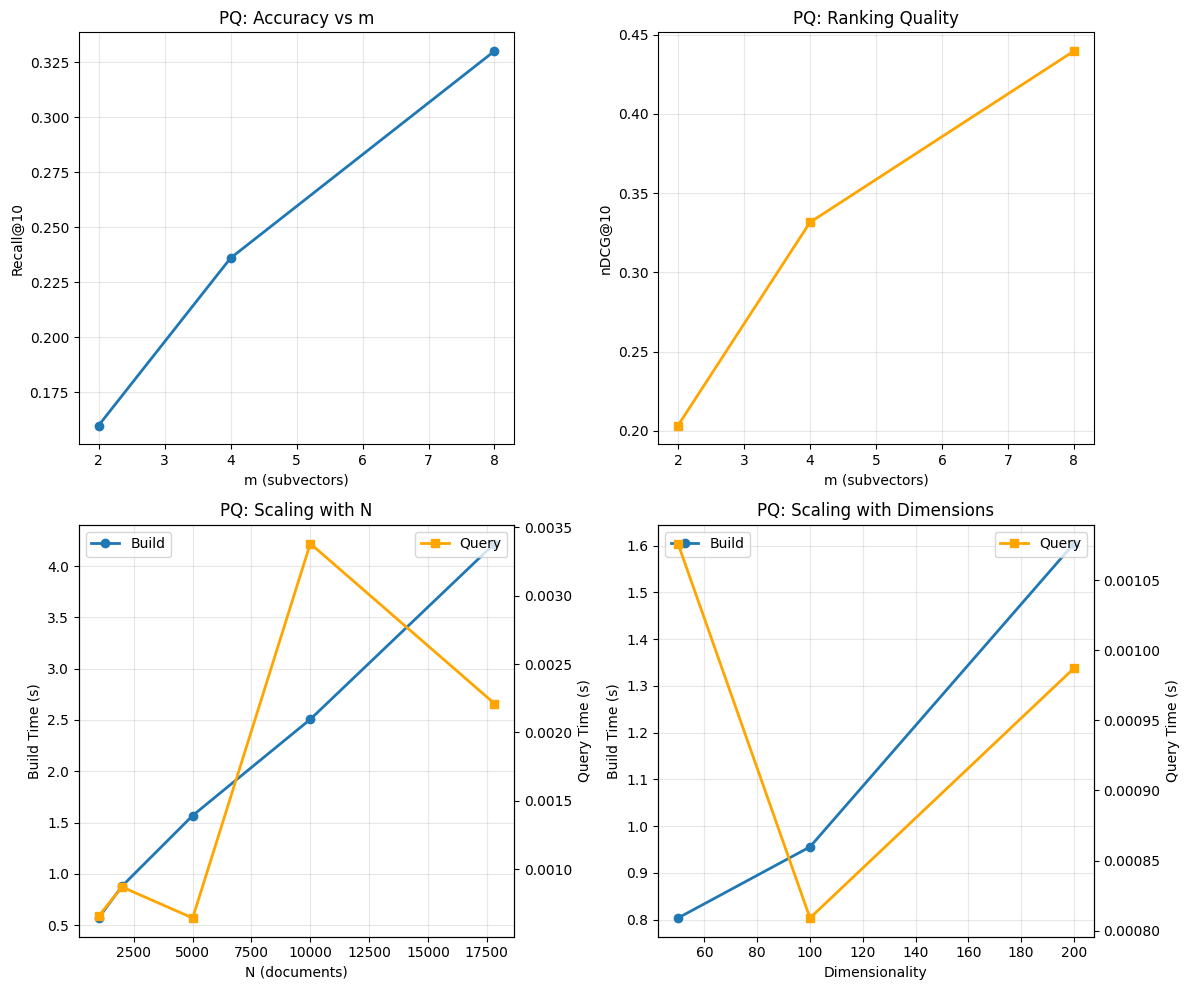

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Recall vs m
axes[0,0].plot(df_exp1["m_subvectors"], df_exp1["recall_at_k"], 'o-', linewidth=2)
axes[0,0].set(xlabel="m (subvectors)", ylabel="Recall@10", 
              title="PQ: Accuracy vs m")
axes[0,0].grid(alpha=0.3)

# nDCG vs m
axes[0,1].plot(df_exp1["m_subvectors"], df_exp1["ndcg_at_k"], 's-', 
               linewidth=2, color='orange')
axes[0,1].set(xlabel="m (subvectors)", ylabel="nDCG@10", 
              title="PQ: Ranking Quality")
axes[0,1].grid(alpha=0.3)

# Scaling with N
ax2 = axes[1,0]
ax2.plot(df_exp2["N"], df_exp2["build_time"], 'o-', label="Build", linewidth=2)
ax2_twin = ax2.twinx()
ax2_twin.plot(df_exp2["N"], df_exp2["query_time"], 's-', color='orange', 
              label="Query", linewidth=2)
ax2.set(xlabel="N (documents)", ylabel="Build Time (s)", 
        title="PQ: Scaling with N")
ax2_twin.set_ylabel("Query Time (s)")
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')
ax2.grid(alpha=0.3)

# Scaling with Dim
ax3 = axes[1,1]
ax3.plot(df_exp3["dim"], df_exp3["build_time"], 'o-', label="Build", linewidth=2)
ax3_twin = ax3.twinx()
ax3_twin.plot(df_exp3["dim"], df_exp3["query_time"], 's-', color='orange', 
              label="Query", linewidth=2)
ax3.set(xlabel="Dimensionality", ylabel="Build Time (s)", 
        title="PQ: Scaling with Dimensions")
ax3_twin.set_ylabel("Query Time (s)")
ax3.legend(loc='upper left')
ax3_twin.legend(loc='upper right')
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{results_dir}/pq_benchmark_summary.png", dpi=150, bbox_inches="tight")
plt.show()